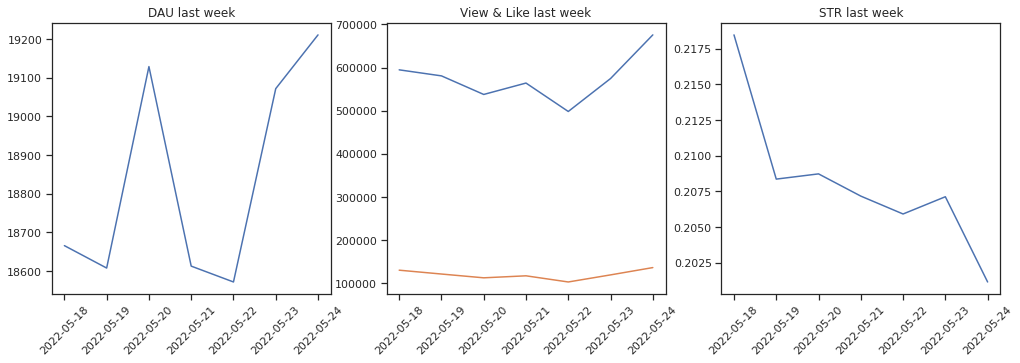

In [4]:
import telegram
#import python-telegram-bot
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from CH import Getch
import os
import pandas as pd
import pandahouse
#import logging
from datetime import date, timedelta

sns.set(style ='ticks')

data_yesterday = Getch(
                        '''
                        select count(distinct user_id) as dau, 
                        countIf(post_id, action = 'view') as view, 
                        countIf(post_id, action = 'like') as like, 
                        countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as STR 
                        from simulator_20220520.feed_actions 
                        where toDate(time) = today()-1
                        '''
                        ).df
yesterday = (date.today() - timedelta(days=1)).strftime('%d-%m-%Y')
text = '''
        Ключевые метрики за {}: 
        DAU                  {} 
        Просмотры     {} 
        Лайки               {} 
        CTR                    {}
        '''.format(yesterday,
                data_yesterday.dau[0],
                data_yesterday.view[0],
                data_yesterday.like[0],
                data_yesterday.STR[0].round(4))
data_last_week = Getch(
                        '''
                        select 
                        toDate(time) as date,
                        count(distinct user_id) as dau, 
                        countIf(post_id, action = 'view') as view, 
                        countIf(post_id, action = 'like') as like, 
                        countIf(post_id, action = 'like')/countIf(post_id, action = 'view') as STR 
                        from simulator_20220520.feed_actions 
                        where toDate(time) > today()-8 and not toDate(time) = today()
                        group by date
                        '''
                        ).df


def send_report(chat=None):
    chat_id = chat or -715060805
    token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
    bot = telegram.Bot(token = token) 
    
    #отправка текста
    bot.sendMessage(chat_id = chat_id, text = text)
    
    #графики
    plt.figure(figsize=(17, 5))

    plt.subplot (1, 3, 1)
    sns.lineplot(data = data_last_week, x = 'date' , y = 'dau')
    plt.title('DAU last week')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('')

    plt.subplot (1, 3, 2)
    sns.lineplot(data = data_last_week, x = 'date' , y = 'view')
    sns.lineplot(data = data_last_week, x = 'date' , y = 'like')
    plt.title('View & Like last week')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('')

    plt.subplot (1, 3, 3)
    sns.lineplot(data = data_last_week, x = 'date' , y = 'STR')
    plt.title('STR last week')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('')

    #отправка графиков
    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.name = 'test_plot.png'
    #Перемещает указатель чтения/записи в файле.
    plot_object.seek(0)
    plt.close

    bot.sendPhoto(chat_id = chat_id, photo = plot_object)
    
    #отправка файла
    file_object = io.StringIO()
    data_last_week.to_csv(file_object)
    file_object.seek(0)

    file_object.name = 'data_last_week.csv'
    bot.sendDocument(chat_id=chat_id,document =file_object)
                                                             
try:
    send_report()
except Exception as e:
    print(e)
    
